# micrograd

In [124]:
import math
import numpy as np
import matplotlib as plt
import random
%matplotlib inline

In [125]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0 # has gradient 0 -> assuming it does not change L
        self._prev = set(_children)
        self._backward = lambda: None # uses the chain rule
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"value: {self.data}"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        # self and other are the parents of out
        # they take the grad of the parent -> due to chain rule
        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        # finding dL/dself = dL/dout * dout/dself = dL/dout * d(self*other)/dself= dL/dout * other
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other.data, (self, ), "**")

        def _backward():
            self.grad += out.grad * other.data * self.data ** (other.data - 1)
        out._backward = _backward
        return out
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other**-1
            
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), "tanh")

        # dL/dself = dL/dout * dout/dself = dL/dout * d(tanh(self))/dself = dL/dout * (1 - tanh(self)**2)
        def _backward():
            self.grad = out.grad * (1 - t**2)

        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visitied = set()
        def build_topo(v):
            if v not in visitied:
                visitied.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [126]:
a = Value(1.0, "a")
2 + a

value: 3.0

In [127]:
from graphviz import Digraph

# TODO
# from https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [128]:
# draw_dot(L)

- a, b, c and f are inputs?
- back prop -> calc grad wrt all inputs -> see how it affects it?

In [129]:
# testing small changes in the input -> to find the grad wrt another var
def local_test():
    h = 0.0001

    a = Value(2, label="a")
    b = Value(-3, label="b")
    c = Value(10, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L1 = d * f; L1.label = "L1"

    a = Value(2, label="a")
    b = Value(-3, label="b")
    c = Value(10, label="c")
    e = a * b; e.label = "d"
    d = e + c; d.label = "e"
    d.data += h # this is the val of f -> L2 = d*f, dL2/dd = f
    f = Value(-2.0, label="f")
    L2 = d * f; L2.label = "L2"

    # print(L2.data)

    print((L2.data - L1.data)/h)

local_test()

-1.9999999999953388


the "+" node -> routes the grad of the parent to the children -> since $d = \Sigma_i c_i$, for any $i$, $\frac{dd}{dc_i} = 1$ & due to the chain rule

this is when finding the $\frac{dL}{dc_i}$

"*" -> grad = product of all sibling vals 

In [130]:
# single neuron

# input
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# biase
b = Value(6.8813735870195432, label="b")

# dot product
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label = "n"
# o = n.tanh(); o.label = "o"

e = (2*n).exp()
o = (e - 1)/(e + 1)

In [131]:
o.backward()

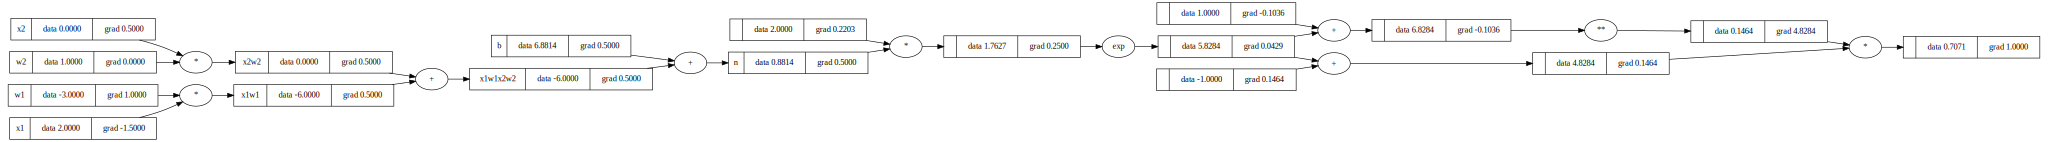

In [132]:
draw_dot(o)

In [133]:
a = Value(2)
b = Value(4)

a**b

value: 16

In [134]:
class Neuron:
    def __init__(self, nin):
        # define a binch of random weights
        # number of weights = number of inputs
        self.w = [ Value(random.uniform(-1, 1)) for _ in range(nin) ]

        # get a random bias
        self.b = Value(random.uniform(-1, 1))
    
    # run when doing: instance(x)
    def __call__(self, x):
        # do the dot product wx -> then add bias
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        # squash output
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        # all neurons in the layer have the same number of inputs -> which it takes from previous layer
        # number of nuerons = number of output -> each output is the output of an indevidual neuron
        self.neurons = [ Neuron(nin) for _ in range(nout) ]
    
    def __call__(self, x):
        # evaulates each neuron and returns their Value (a value from -1 -> 1)
        outs = [ n(x) for n in self.neurons ]
        return outs if len(outs) > 1 else outs[0]
    
class MLP:
    def __init__(self, nin, nout):
        # creates array such that:
        # [input, output1, output2, ...]
        # where each value shows the number of inputs/outputs of a layer
        vals = [nin] + nout
        self.layers = [ Layer(vals[i], vals[i+1]) for i in range(len(nout)) ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

x = [2, 3, -1]
test = MLP(3, [4, 4, 1])
test(x)

value: 0.8323293795191217

In [152]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]

ys = [1, -1, -1 , 1]
ypred = [test(x) for x in xs]
ypred

[value: 0.8323293795191217,
 value: -0.217217205634503,
 value: 0.3822881528760746,
 value: 0.5296670404712952]

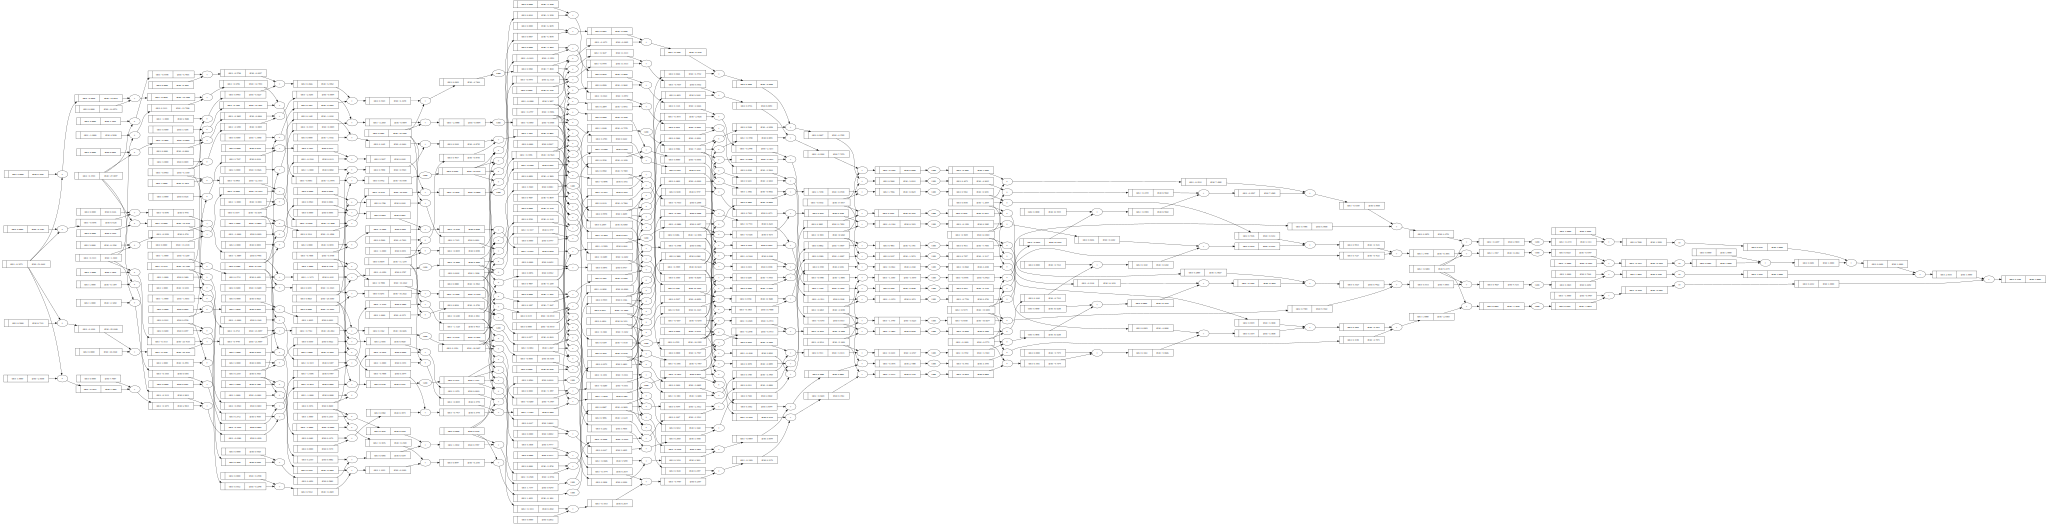

In [155]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()

draw_dot(loss)